# Mining multiple pathogen-host protein interactomes for the detection of shared patterns.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Mining-multiple-pathogen-host-protein-interactomes-for-the-detection-of-shared-patterns." data-toc-modified-id="Mining-multiple-pathogen-host-protein-interactomes-for-the-detection-of-shared-patterns.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Mining multiple pathogen-host protein interactomes for the detection of shared patterns.</a></span></li><li><span><a href="#Data-collection-and-exploration" data-toc-modified-id="Data-collection-and-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data collection and exploration</a></span><ul class="toc-item"><li><span><a href="#Protein-protein-interaction-data-sources" data-toc-modified-id="Protein-protein-interaction-data-sources-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Protein-protein interaction data sources</a></span><ul class="toc-item"><li><span><a href="#Data-filtering-and-clean-up" data-toc-modified-id="Data-filtering-and-clean-up-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Data filtering and clean-up</a></span></li><li><span><a href="#Taxonomic-diversity-of-data-set" data-toc-modified-id="Taxonomic-diversity-of-data-set-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Taxonomic diversity of data set</a></span><ul class="toc-item"><li><span><a href="#Inter-viral-interactions" data-toc-modified-id="Inter-viral-interactions-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Inter-viral interactions</a></span></li></ul></li><li><span><a href="#Protein-diversity" data-toc-modified-id="Protein-diversity-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Protein diversity</a></span></li></ul></li><li><span><a href="#Annotation-data" data-toc-modified-id="Annotation-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Annotation data</a></span><ul class="toc-item"><li><span><a href="#Gene-Ontology" data-toc-modified-id="Gene-Ontology-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Gene Ontology</a></span></li><li><span><a href="#InterPro-Domains" data-toc-modified-id="InterPro-Domains-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>InterPro Domains</a></span></li></ul></li><li><span><a href="#Check-overlap-between-data-sets" data-toc-modified-id="Check-overlap-between-data-sets-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Check overlap between data sets</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Data collection and exploration

In [1]:
import os, sys
# setup correct path to script files
from pathlib import Path
my_file = Path("main.py")
if not my_file.is_file():
    import sys,os
    os.chdir('../src/ppi_tools/')
    sys.path.append('../src/')
sys.path.append(os.path.abspath('..'))    

import argparse
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from IPython.display import display, HTML # pretty tables

import id_mapper
import label_go
import label_interpro
import ppi_import
from data_prep import retrieve_taxids
from go_tools import gaf_parser
from go_tools import obo_tools
from main import *

# run main script to annotate and convert PPI datasets into a format suitable for frequent item set mining.
# and suppress output
# %run main.py -d

## Protein-protein interaction data sources
The protein-protein interaction (PPI) datasets were retrieved from the following sources.

- The HPIDB 2.0 dataset was retrieved from: [http://www.agbase.msstate.edu/hpi/downloads/hpidb2.mitab.zip]. [^fn1]
- The VirHostNet 2.0 dataset is available from: [http://virhostnet.prabi.fr/] (release January 2017).[^fn2]
- The PHISTO dataset was obtained from [http://www.phisto.org/index.xhtml] by using the browse utility (Data update: January 19, 2017).[^fn3]
- The PSI-MI ontology .obo file was downloaded from [http://ontologies.berkeleybop.org/mi.obo] (data-version: releases/2017-06-14).[^fn4]

The different primary data sources in the are:

In [2]:
%%bash
printf 'HPIDB2:\n'
tail -n +2 ../../data/raw/ppi_data/hpidb2_March14_2017_mitab_plus.txt | cut -f1 | sed -r 's/(^.*):.*/\1/g' | sort -u
printf "\nVirHostNet:\n"
tail -n +2 ../../data/raw/ppi_data/VirHostNet_January_2017.txt | cut -f1 | sed -r 's/(^.*):.*/\1/g' | sort -u

HPIDB2:
ensembl
entrez gene/locuslink
intact
uniprotkb

VirHostNet:
refseq
uniprotkb


- HPIDB2
    - uniprotkb
    - intact
    - ensembl
    - entrez gene/locuslink
- VirHosNet
    - uniprotkb
    - refseq
- PHISTO
    - uniprotkb

### Data filtering and clean-up

All PPIs pertaining to the Herpesviridae familiy were extracted from the above PPI datasets.

In [3]:
%%capture
# create taxid dictionaries
name2taxid, taxid2name = retrieve_taxids.parse_taxid_names(r'../../data/raw/taxdump/names.dmp')
with Path(r'../../data/interim/child_taxids_of_10292.txt').open() as taxid_file:
        herpes_taxids = [str('taxid:' + line.split('|')[0]) for line in taxid_file]
# print([taxid2name[i[6:]] for i in herpes_taxids])
df_virhost = ppi_import.read_mitab_virhost(r'../../data/raw/ppi_data/VirHostNet_January_2017.txt')

df_hpidb2 = ppi_import.read_mitab_hpidb2(r'../../data/raw/ppi_data/hpidb2_March14_2017_mitab_plus.txt')

df_phisto = ppi_import.read_mitab_phisto(r'../../data/raw/ppi_data/phisto_Jan19_2017.csv',
                                         r'../../data/raw/ppi_data/mi.obo')
df_concat = concat_interaction_datasets([df_hpidb2, df_virhost, df_phisto])
# filter on Herpesviridae
df_herpes = df_concat.loc[(df_concat.taxid_A.isin(herpes_taxids)) | df_concat.taxid_B.isin(herpes_taxids)]
df_herpes = df_herpes.reset_index(drop=True)
# create combined identifier
xref_partners_sorted_array = np.sort(np.stack((df_herpes.xref_A, df_herpes.xref_B), axis=1), axis=1)
xref_partners_df = pd.DataFrame(xref_partners_sorted_array, columns=['A', 'B'])
df_herpes['xref_partners_sorted'] = xref_partners_df['A'] + '%' + xref_partners_df['B']

In [4]:
display(df_herpes.groupby('origin').size())

origin
HPIDB2         8231
PHISTO         7946
VirHostNet2    5446
dtype: int64

Duplicated entries were removed. One example of duplicate PPI entries could be those for which the same two proteins interact, but which differ in pathogen sources (because strains share proteins), publication or experimental method. Whenever possible, the HPIDB2 entries were preferentially retained.

Overall, these data sets also exhibit a substantial amount of overlap between them, since both the VirHostNet2 and PHISTO data sets were substantially reduced after this operation.

In [5]:
print(np.sum(df_herpes.duplicated(subset=['xref_partners_sorted'])), 'duplicated PPIs were removed.')
df_herpes = df_herpes.drop_duplicates(subset=['xref_partners_sorted'], keep='first')
df_herpes = df_herpes.reset_index(drop=True)
display(df_herpes.groupby('origin').size())

12835 duplicated PPIs were removed.


origin
HPIDB2         6858
PHISTO          835
VirHostNet2    1095
dtype: int64

Only inter-species PPIs were retained.

Original data set size: 8788 
Only inter-species PPI: 7904 
Number of removed PPIs: 884


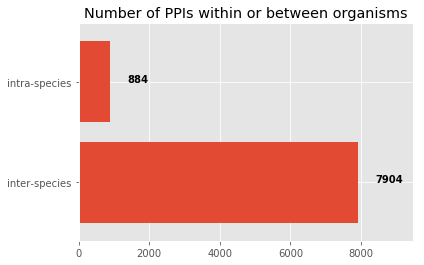

In [6]:
annotate_inter_intra(df_herpes)
df_inter_intra = df_herpes.copy()
df_herpes = df_herpes[df_herpes['inter-intra'] == 'inter-species']
df_herpes = df_herpes.reset_index(drop=True)
print('Original data set size:', df_inter_intra.shape[0], '\nOnly inter-species PPI:', 
      df_herpes.shape[0], '\nNumber of removed PPIs:', df_inter_intra.shape[0] - df_herpes.shape[0])
# inter-intra plot
height = df_inter_intra.groupby('inter-intra').size()
bars = df_inter_intra.groupby('inter-intra').size().index
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+500 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
# plt.tight_layout(pad=0)
plt.margins(0.2, 0.1)
# plt.subplots_adjust(right=2.3)
plt.title('Number of PPIs within or between organisms')
plt.show()

All protein identifiers were mapped to `UniProtKB`s, except for a number of `intact:EBI`s, `entrez gene/locuslink`s  and `refseq`s for which no corresponding UniProtKB was found.

78 + 167 additional PPIs were removed because a) no valid mapping to UniProt accession numbers were found or b) multiple mappings were found. Retaining the latter would artificially inflate counts during frequent item set mining. 

In [7]:
id_mapper.map2uniprot(df_herpes, filepath=r'../../data/interim/mappings/')
df_herpes = id_mapper.remove_mult(df_herpes)

## adding
df_herpes.reset_index(inplace=True, drop=True)


unmapped = df_herpes.loc[~(df_herpes['xref_A'].str.contains('uniprotkb:') &
                           df_herpes['xref_B'].str.contains('uniprotkb:'))]
print('Unmapped proteins:',unmapped.shape[0])
df_herpes = df_herpes.loc[(df_herpes['xref_A'].str.contains('uniprotkb:') & # only select remapped entries
                           df_herpes['xref_B'].str.contains('uniprotkb:'))] 
# TO THIS BEFORE CREATING
df_herpes.reset_index(inplace=True, drop=True)
# re-create combined identifier
xref_partners_sorted_array = np.sort(np.stack((df_herpes.xref_A, df_herpes.xref_B), axis=1), axis=1)
xref_partners_df = pd.DataFrame(xref_partners_sorted_array, columns=['A', 'B'])
df_herpes['xref_partners_sorted'] = xref_partners_df['A'] + '%' + xref_partners_df['B']

Converted all found identifiers to UniProt ACs.
Omitted 167 PPIs due to the existance of multiple mappings.
Unmapped proteins: 78


Surprisingly, the re-mapping resulted in a number of new duplicates!

In [8]:
print(np.sum(df_herpes.duplicated(subset=['xref_partners_sorted'])), 'duplicated PPIs were removed.')
df_herpes = df_herpes.drop_duplicates(subset=['xref_partners_sorted'], keep='first')
df_herpes = df_herpes.reset_index(drop=True)

295 duplicated PPIs were removed.


For example, the following interaction was catalogued once for _Human herpesvirus 8 strain GK18_ and once for the higher order _Human gammaherpesvirus 8_. These issues could be resolved by filtering on both PPI partners **and** their taxids.

In [9]:
display(df_herpes.loc[df_herpes.xref_partners_sorted=='uniprotkb:Q13547%uniprotkb:Q2HR82'])
display(df_concat.loc[df_concat.interaction_identifiers=='biogrid:669512'])
display(df_concat.loc[df_concat.interaction_identifiers=='intact:EBI-9006990|imex:IM-21800-6'])

,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B,xref_partners_sorted,inter-intra
6,psi-mi:hdac1_human(display_long)|uniprotkb:HDAC1(gene name)|psi-mi:HDAC1(display_short)|uniprotkb:RPD3L1(gene name synonym),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301834|uniprotkb:Q92534,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.43,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),HPIDB2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q13547,uniprotkb:Q2HR82,uniprotkb:Q13547%uniprotkb:Q2HR82,inter-species


,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B
1775,entrez gene/locuslink:GON-10(gene name synonym)|entrez gene/locuslink:HD1(gene name synonym)|entrez gene/locuslink:RPD3(gene name synonym)|entrez gene/locuslink:RPD3L1(gene name synonym),-,biogrid:109315|entrez gene/locuslink:HDAC1|entrez gene/locuslink:RP4-811H24.2,biogrid:1776965|entrez gene/locuslink:K8|entrez gene/locuslink:HHV8GK18_gp54,Martinez FP (2012),-,psi-mi:MI:0004(affinity chromatography technology),NaN,NaN,biogrid:669512,psi-mi:MI:0915(physical association),HPIDB2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,Homo sapiens,VIRUS,Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134,BioGRID,psi-mi:MI:0463(biogrid),taxid:9606,taxid:37296,entrez gene/locuslink:3065,entrez gene/locuslink:4961462


,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B
106,psi-mi:hdac1_human(display_long)|uniprotkb:HDAC1(gene name)|psi-mi:HDAC1(display_short)|uniprotkb:RPD3L1(gene name synonym),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301834|uniprotkb:Q92534,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.43,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),HPIDB2,NaN,MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKANAEEMTKYHSDDYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVASAVKLNKQQTDIAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMTV...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC1_HUMAN,UNIPROT_AC:Q13547,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q13547,uniprotkb:Q2HR82
108,psi-mi:hdac2_human(display_long)|uniprotkb:HDAC2(gene name)|psi-mi:HDAC2(display_short),psi-mi:kbzip_hhv8p(display_long)|uniprotkb:K8(gene name)|psi-mi:K8(display_short),intact:EBI-301821|uniprotkb:B4DL58|uniprotkb:E1P561|uniprotkb:B3KRS5|uniprotkb:Q5SRI8|uniprotkb:Q5SZ86|uniprotkb:Q8NEH4,intact:EBI-9006943,Martínez et al. (2012),intact-miscore:0.54,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9006990|imex:IM-21800-6,psi-mi:MI:0914(association),HPIDB2,NaN,MAYSQGGGKKKVCYYYDGDIGNYYYGQGHPMKPHRIRMTHNLLLNYGLYRKMEIYRPHKATAEEMTKYHSDEYIKFLRSIRPDNMSEYSKQMQRFNVGEDCPVFDGLFEFCQLSTGGSVAGAVKLNRQQTDMAVNWAGGLHHAKKSEASGFCYVNDIVLAILELLKYHQRVLYIDIDIHHGDGVEEAFYTTDRVMT...,MPRMKDIPTKSSPGTDNSEKDEAVIEEDLSLNGQPFFTDNTDGGENEVSWTSSLLSTYVGCQPPAIPVCETVIDLTAPSQSGAPGDEHLPCSLNAETKFHIPDPSWTLSHTPPRGPHISQQLPTRRSKRRLHRKFEEERLCTKAKQGAGRPVPASVVKVGNITPHYGEELTRGDAVPAAPITPPYPRVQRPAQPTH...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,HDAC2_HUMAN,UNIPROT_AC:Q92769,KBZIP_HHV8P,UNIPROT_AC:Q2HR82,pubmed:22416134|imex:IM-21800,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:Q92769,uniprotkb:Q2HR82


As a side-note: this also displays another discrepancy in the data set. The interaction `intact:EBI-9006990|imex:IM-21800-6` id is actually used for two separate PPIs, between _uniprotkb:Q13547_ & _uniprotkb:Q2HR82_ and between _uniprotkb:Q92769_ & _uniprotkb:Q2HR82_. The human proteins are Histone deacetylase 1/2 and the pathogen virus is a HHV-8 E3 SUMO-protein ligase. Due to our filtering on unique protein id - protein id pairs, this should not be an issue for us.

The majority of PPI interactions are of the type (physical) association.

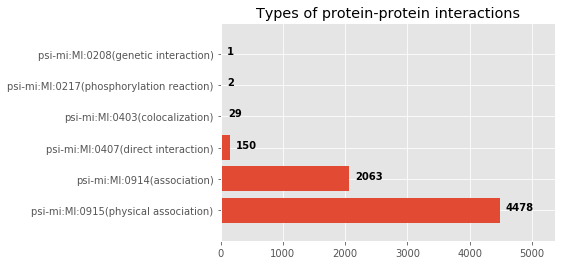

In [10]:
height = df_herpes['interaction_type'].value_counts()
bars = height.index
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+100 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
plt.margins(0.2, 0.1)
plt.title('Types of protein-protein interactions')
plt.show()

### Taxonomic diversity of data set

The final data set consists of 7364 unique PPI between Herpesviridae and the following hosts. As expected, human interaction make up the bulk of this data set (7035 out of the 7364 PPis). The majority of hosts are only represented by one or two PPIs.
Also, there seems to be one entry describing an interaction between *Arabidopsis* and Human Herpes Simplex Virus 1 (https://www.ncbi.nlm.nih.gov/pubmed/25150167). 

In [11]:
all_taxids = df_herpes['taxid_A'].append(df_herpes['taxid_B']).unique()
host_taxids = list(np.setdiff1d(all_taxids, herpes_taxids))
host_list = []
for i in host_taxids:
    taxid = i.split(':')[1]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['taxid_A'] == i) | (df_herpes['taxid_B'] == i)].shape[0]
    host_list.append({'Taxid' : taxid, 'Name' : taxid2name[taxid], 'Count' : count})
host_df = pd.DataFrame(host_list).sort_values('Count', ascending=False)
display(host_df)
reorder_pathogen_host_entries(df_herpes, host_taxids)

,Count,Name,Taxid
14,7035,Homo sapiens,9606
1,58,Rattus norvegicus,10116
0,29,Mus musculus,10090
17,23,Bos taurus,9913
9,7,Gallus gallus,9031
15,6,Equus caballus,9796
13,4,Pongo abelii,9601
16,3,Sus scrofa,9823
5,2,Caenorhabditis elegans,6239
11,2,Macaca fascicularis,9541


In [29]:
df_herpes.loc[df_herpes.taxid_A=='taxid:3702']

,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B,xref_partners_sorted,inter-intra,pathogen_groups,xref_A_GO,xref_B_GO,interpro_A,interpro_B
1655,psi-mi:med25_arath(display_long)|uniprotkb:MED25(gene name)|psi-mi:MED25(display_short)|uniprotkb:MED25_1(gene name synonym)|uniprotkb:PFT1(gene name synonym)|uniprotkb:Phytochrome and flowering t...,psi-mi:vp16_hhv11(display_long)|uniprotkb:Vmw65(gene name synonym)|uniprotkb:ICP25(gene name synonym)|uniprotkb:Alpha-TIF(gene name synonym)|uniprotkb:Alpha trans-inducing protein(gene name synony...,intact:EBI-1386292|uniprotkb:F4ICJ2|uniprotkb:Q9C6M3,intact:EBI-7489933|uniprotkb:Q09I86|intact:MINT-275736|uniprotkb:B9VQH6,Fujiwara et al. (2014),intact-miscore:0.51,psi-mi:MI:0809(bimolecular fluorescence complementation),NaN,NaN,intact:EBI-9685262|imex:IM-23059-2,psi-mi:MI:0915(physical association),HPIDB2,NaN,MSSEVKQLIVVAEGTAALGPYWQTIVSDYLEKIIRSFCGSELNGERNPVSTVELSLVIFNSHGSYCACLVQRSGWTRDVDIFLHWLSSIQFGGGGFNEVATAEGLAEALMMFSPPSGQAQPSNDLKRHCILITASNPHILPTPVYRPRLQNVERNENGDAQAESRLSDAETVASYFAKCSVSLSVVCPKQLPTIRA...,MDLLVDELFADMNADGASPPPPRPAGGPKNTPAAPPLYATGRLSQAQLMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSALPTNADLYRECKFLSTLPSDVVEWGDAYVPERTQIDIRAHGDVAFPTLPATRDGLGLYYEALSRFFHAELRAREESYRTVLANFCSALYRYLRASVRQLHRQAHM...,PLANT,arath|Arabidopsis thaliana (Mouse-ear cress),VIRUS,hhv11|Human herpesvirus 1 (strain 17) (HHV-1),MED25_ARATH,UNIPROT_AC:Q7XYY2,VP16_HHV11,UNIPROT_AC:P06492,pubmed:25150167|imex:IM-23059,MINT,psi-mi:MI:0471(MINT),taxid:3702,taxid:10299,uniprotkb:Q7XYY2,uniprotkb:P06492,uniprotkb:P06492%uniprotkb:Q7XYY2,inter-species,human_hsv1,h@GO:0050794;h@GO:2000241;h@GO:0048856;h@GO:0044238;h@GO:0044446;h@GO:0009605;h@GO:0051707;h@GO:0051606;h@GO:0071704;h@GO:0044237;h@GO:0048583;h@GO:0050793;h@GO:1901363;h@GO:0000988;h@GO:0003006;h...,v@GO:0050794;v@GO:0005198;v@GO:0044238;v@GO:0071704;v@GO:0044237;v@GO:0019083;v@GO:0033647;v@GO:0044419;v@GO:1901363;v@GO:0039713;v@GO:0016043;v@GO:0000988;v@GO:0033655;v@GO:0043900;v@GO:0008134;v...,h@IPR021419,v@IPR021051;v@IPR003174


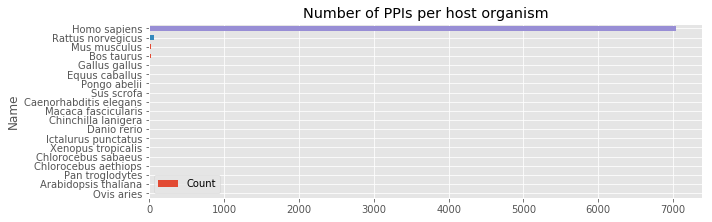

In [12]:
host_df.sort_values('Count').plot(x='Name',y='Count', kind="barh", width=0.5,figsize=(10, 3))
plt.tight_layout()
plt.title('Number of PPIs per host organism')
plt.show()

In [13]:
herpes_taxids = list(np.setdiff1d(all_taxids, host_taxids))
pathogen_list = []
for i in herpes_taxids:
    taxid = i.split(':')[1]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['taxid_A'] == i) | (df_herpes['taxid_B'] == i)].shape[0]
    pathogen_list.append({'Taxid' : taxid, 'Name' : taxid2name[taxid], 'Count' : count})
path_df = pd.DataFrame(pathogen_list).sort_values('Count', ascending=False)
display(path_df)

,Count,Name,Taxid
24,2171,Human herpesvirus 4 strain B95-8,10377
45,2159,Epstein-barr virus strain ag876,82830
1,849,Herpes simplex virus (type 1 / strain 17),10299
37,409,Murid gammaherpesvirus 4,33708
40,386,Human gammaherpesvirus 8,37296
23,346,Human gammaherpesvirus 4,10376
48,262,Human herpesvirus 8 strain GK18,868565
41,190,Human herpesvirus 8 type M,435895
0,135,Human alphaherpesvirus 1,10298
38,87,Human herpesvirus 3 strain Oka vaccine,341980


The viruses were also mapped to a higher taxonomic grouping for clarity.

In [14]:
taxid_nodes_path = Path(r'../../data/raw/taxdump/nodes.dmp')
taxid2parent, taxid2rank = retrieve_taxids.parse_taxid_nodes(str(taxid_nodes_path))
parent2child = retrieve_taxids.create_parent2child_dict(taxid2parent)
pathogen_group_dict = {'bovine_ah1': '10320', 'bovine_hv1': '79889', 'epstein_barr': '10376', 'equid_av1': '10326',
                       'equid_gv2': '12657', 'gallid_av2': '10390', 'human_hsv1': '10298', 'saimiri_gv2': '10381',
                       'human_av2': '10310', 'human_av3': '10335', 'human_bv5': '10359', 'human_gv8': '37296',
                       'human_bv6A': '32603', 'human_bv6B': '32604', 'murid_bv1': '10366', 'murid_gv4': '33708',
                       'papiine_gv1': '106332', 'suid_av1': '10345', 'bovine_gv4': '10385', 'ateline_gv3': '85618', 
                       'elephantid_bv1': '146015'}

for i, j in pathogen_group_dict.items():
    pathogen_group_dict[i] = [j] + retrieve_taxids.get_children(j, parent2child)

df_herpes['pathogen_groups'] = df_herpes.apply(lambda x: pathogen_group_mapper(x['taxid_B'].split(':')[1],
                                                                               pathogen_group_dict), axis=1)

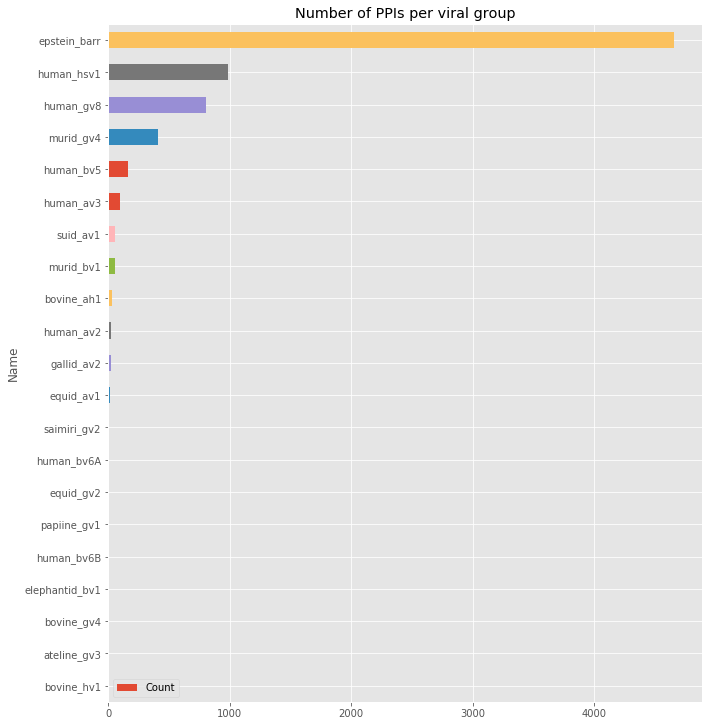

In [15]:
pathogen_higher_list = []
for i in pathogen_group_dict:
    taxid = pathogen_group_dict[i]
    count = df_herpes['xref_partners_sorted'].loc[(df_herpes['pathogen_groups'] == i)].shape[0]
    pathogen_higher_list.append({'Taxid' : taxid, 'Name' : i, 'Count' : count})
pathogen_higher_df = pd.DataFrame(pathogen_higher_list).sort_values('Count', ascending=False)
pathogen_higher_df.sort_values('Count').plot(x='Name',y='Count', kind="barh", width=0.5,figsize=(10, 10))
plt.tight_layout()
plt.title('Number of PPIs per viral group')
plt.show()

#### Inter-viral interactions

As was mentioned above, this data set only contains PPIs between different organisms, i.e. our intent was to collect host-pathogen interactions. To this end we merely filtered out interactions where both protein partners belonged to the same organism. However, 186 PPIs are actually interactions between two different viruses. Interestingly, the converse (PPIs between two hosts) never occurred.

In [16]:
print('Number of inter-viral PPIs:', df_herpes.loc[(df_herpes.taxid_A.isin(herpes_taxids) & df_herpes.taxid_B.isin(herpes_taxids)),:].shape[0])
print('Number of inter-host PPIs:', df_herpes.loc[~(df_herpes.taxid_A.isin(herpes_taxids) | df_herpes.taxid_B.isin(herpes_taxids)),:].shape[0])

Number of inter-viral PPIs: 186
Number of inter-host PPIs: 0


### Protein diversity

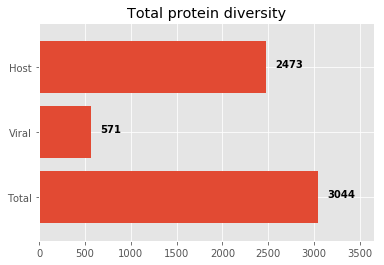

In [17]:
protein_set = set(df_herpes.xref_A.append(df_herpes.xref_B, ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
viral_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(herpes_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(herpes_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
host_protein_set = set(df_herpes.xref_A[df_herpes.taxid_A.isin(host_taxids)].append(df_herpes.xref_B[df_herpes.taxid_B.isin(host_taxids)], ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
height = [len(x) for x in [protein_set, viral_protein_set, host_protein_set]]
bars = ['Total','Viral','Host']
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.yticks(y_pos, bars)
for i in range(len(y_pos)):
    plt.text(x = height[i]+100 , y = y_pos[i], s = height[i], size = 10, fontweight = 'bold')
plt.margins(0.2, 0.1)
plt.title('Total protein diversity')
plt.show()

## Annotation data

All of the PPIs were labeled with two types of meta-data, which will be used for the subsequent frequent item set mining methods later in the analysis. The annotation data that was used for the labeling was Gene Ontology (GO) and InterPro domain information for both partners in a PPI.

In [24]:
df_herpes

,aliases_A,aliases_B,alt_identifiers_A,alt_identifiers_B,author,confidence_score,detection_method,display_id_A,display_id_B,interaction_identifiers,interaction_type,origin,pathogen,protein_seq1,protein_seq2,protein_taxid_1_cat,protein_taxid_1_name,protein_taxid_2_cat,protein_taxid_2_name,protein_xref_1_display_id,protein_xref_1_unique,protein_xref_2_display_id,protein_xref_2_unique,publication,source_database,source_database_ids,taxid_A,taxid_B,xref_A,xref_B,xref_partners_sorted,inter-intra,pathogen_groups,xref_A_GO,xref_B_GO,interpro_A,interpro_B
0,psi-mi:cdk2_human(display_long)|uniprotkb:CDK2(gene name)|psi-mi:CDK2(display_short)|uniprotkb:p33 protein kinase(gene name synonym)|uniprotkb:Cell division protein kinase 2(gene name synonym)|uni...,psi-mi:vcycl_hhv8p(display_long)|uniprotkb:ORF72(gene name)|psi-mi:ORF72(display_short),intact:EBI-375096|uniprotkb:A8K7C6|uniprotkb:O75100,intact:EBI-9082484|uniprotkb:D0UZU0,Platt et al. (2000),intact-miscore:0.40,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9082527|imex:IM-21981-2,psi-mi:MI:0915(physical association),HPIDB2,NaN,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEM...,MATANNPPSGLLDPTLCEDRIFYNILEIEPRFLTSDSVFGTFQQSLTSHMRKLLGTWMFSVCQEYNLEPNVVALALNLLDRLLLIKQVSKEHFQKTGSACLLVASKLRSLTPISTSSLCYAAADSFSRQELIDQEKELLEKLAWRTEAVLATDVTSFLLLKLLGGSQHLDFWHHEVNTLITKALVDPKTGSLPASI...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,CDK2_HUMAN,UNIPROT_AC:P24941,VCYCL_HHV8P,UNIPROT_AC:Q77Q36,pubmed:10873769|imex:IM-21981,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:P24941,uniprotkb:Q77Q36,uniprotkb:P24941%uniprotkb:Q77Q36,inter-species,human_gv8,h@GO:0022402;h@GO:0050794;h@GO:0000307;h@GO:0051716;h@GO:0048856;h@GO:0044238;h@GO:0044446;h@GO:0048519;h@GO:0043228;h@GO:0044444;h@GO:0019904;h@GO:0097367;h@GO:0071704;h@GO:0044237;h@GO:0048583;h...,v@GO:0044763,h@IPR011009;h@IPR017441;h@IPR008271;h@IPR000719,v@IPR013763;v@IPR015451;v@IPR006671;v@IPR017285;v@IPR015164
1,psi-mi:cdk4_human(display_long)|uniprotkb:CDK4(gene name)|psi-mi:CDK4(display_short)|uniprotkb:Cell division protein kinase 4(gene name synonym)|uniprotkb:PSK-J3(gene name synonym),psi-mi:vcycl_hhv8p(display_long)|uniprotkb:ORF72(gene name)|psi-mi:ORF72(display_short),intact:EBI-295644|uniprotkb:Q6FG61|uniprotkb:B4DNF9|uniprotkb:B2R9A0|uniprotkb:O00576,intact:EBI-9082484|uniprotkb:D0UZU0,Platt et al. (2000),intact-miscore:0.40,psi-mi:MI:0006(anti bait coimmunoprecipitation),NaN,NaN,intact:EBI-9082540|imex:IM-21981-3,psi-mi:MI:0915(physical association),HPIDB2,NaN,MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVD...,MATANNPPSGLLDPTLCEDRIFYNILEIEPRFLTSDSVFGTFQQSLTSHMRKLLGTWMFSVCQEYNLEPNVVALALNLLDRLLLIKQVSKEHFQKTGSACLLVASKLRSLTPISTSSLCYAAADSFSRQELIDQEKELLEKLAWRTEAVLATDVTSFLLLKLLGGSQHLDFWHHEVNTLITKALVDPKTGSLPASI...,ANIMAL,human|Homo sapiens,VIRUS,hhv8p|Human herpesvirus 8,CDK4_HUMAN,UNIPROT_AC:P11802,VCYCL_HHV8P,UNIPROT_AC:Q77Q36,pubmed:10873769|imex:IM-21981,UniProt,psi-mi:MI:0486(UniProt),taxid:9606,taxid:868565,uniprotkb:P11802,uniprotkb:Q77Q36,uniprotkb:P11802%uniprotkb:Q77Q36,inter-species,human_gv8,h@GO:0044877;h@GO:0022402;h@GO:0040008;h@GO:0050794;h@GO:0000307;h@GO:0051716;h@GO:0048856;h@GO:0009719;h@GO:0044238;h@GO:0044446;h@GO:0048519;h@GO:0043228;h@GO:0009605;h@GO:0044444;h@GO:0097367;h...,v@GO:0044763,h@IPR011009;h@IPR017441;h@IPR008271;h@IPR000719,v@IPR013763;v@IPR015451;v@IPR006671;v@IPR017285;v@IPR015164
2,psi-mi:rack1_human(display_long)|uniprotkb:RACK1(gene name)|psi-mi:RACK1(display_short)|uniprotkb:Cell proliferation-inducing gene 21 protein(gene name synonym)|uniprotkb:GNB2L1(gene name synonym)...,psi-mi:bzlf1_ebvb9(display_long)|uniprotkb:Zebra(gene name synonym)|uniprotkb:BZLF1

### Gene Ontology

Each protein in the PPI data set was labeled with its GO terms. All three namespaces were used: _biological process_, _molecular function_ and _cellular location_.

In [18]:
%%capture
go_dict = obo_tools.importOBO(r'../../data/raw/go_data/go.obo')
obo_tools.buildGOtree(go_dict, root_nodes=['GO:0008150', 'GO:0005575', 'GO:0003674'])
protein_set = set(df_herpes.xref_A.append(df_herpes.xref_B, ignore_index=True).str.extract('^.*:(\w*)-?',expand=False).unique())
gaf_dict = gaf_parser.importGAF(r'../../data/raw/go_data/gene_association_hosts_10292.goa', protein_set)
label_go.annotate_GO(df_herpes, gaf_dict)

114 proteins lacked any GO terms, the majority of which were viral (84), which was to be expected.

In [19]:
not_annotated = [i for i in protein_set if i not in gaf_dict]
print(len(not_annotated), 'proteins lacked GO terms.')
a_multiset = collections.Counter(not_annotated)
b_multiset = collections.Counter(viral_protein_set)
overlap = list((a_multiset & b_multiset).elements())
print(len(overlap), 'proteins were of viral origin.')

114 proteins lacked GO terms.
84 proteins were of viral origin.


To reduce redundancy, all GO terms were remapped upwards to a specific depth. I.e. terms were made less specific to reduce the amount of unique terms. This *lower resolution* makes sense in this context because our ultimate goal was to find general similarities between various PPIs. If extremely specific labels were considered, very few frequently co-occurring terms would be found during the item set mining step of this analysis.

The following depths were selected, while excluding a number of terms that were deemed *too general*. We understand that this selection of terms seems arbitrary, but unfortunately the nature of the GO hierarchy does not lend itself to strict cut-offs. Indeed, the semantic content of a term with a depth of 4 in one branch, might be much higher than a term with depth 6 in another branch. Moreover, terms can have different depths depending on which branch is considered.

Note: the minimal depth was always assigned here. The depth of the root node was set to zero.

    A more nuanced approach would be to look at the information content of nodes to decide whether or not they should be included or excluded. See Alterovitz et al. (2007) and Mazandu & Mulder (2014) for more information. 

In [20]:
%%capture
depth = {'biological_process': 2, 'molecular_function': 1, 'cellular_component': 1}
exclusion = {'GO:0005623': 'cell', 'GO:0005488': 'binding', 'GO:0043226': 'organelle',
             'GO:0044422': 'organelle part', 'GO:0044464': 'cell part', 'GO:0033643': 'host cell part',
             'GO:0033646': 'host intracellular part', 'GO:0043656': 'intracellular region of host',
             'GO:0043657': 'host cell', 'GO:0018995': 'host', 'GO:0044424': 'intracellular part',
             'GO:0016032': 'viral process', 'GO:0044215': 'other organism',
             'GO:0050789': 'regulation of biological process', 'GO:0005515': 'protein binding',
             'GO:0019012': 'virion', 'GO:0044423': 'virion part'}
label_go.remap_GO_depth(df_herpes, depth, go_dict, list(exclusion))
label_host_pathogen(df_herpes, herpes_taxids, columns=['xref_A_GO', 'xref_B_GO'],
                        taxid_columns=['taxid_A', 'taxid_B'])

### InterPro Domains

In addition to the GO labels, InterPro domain 

In [23]:
# Get set of unique ACs
unique_ac = set(pd.unique(df_concat['xref_B'].str.extract('^.*:(\w*)-?', expand=False).append(df_concat['xref_A'].str.extract('^.*:(\w*)-?', expand=False), ignore_index=True)))
uniprot2interpro = label_interpro.create_uniprot2interpro_dict(unique_ac, filepath=r'../../data/interim/interpro_data/protein2ipr_filtered.txt')
label_interpro.annotate_interpro(df_herpes, uniprot2interpro)
label_host_pathogen(df_herpes, herpes_taxids, columns=['interpro_A', 'interpro_B'], taxid_columns=['taxid_A', 'taxid_B'])

## Check overlap between data sets
First column shows unique values for Phisto, second for HPIDB2 and third is shared.

# References
- Ammari, Mais G., Cathy R. Gresham, Fiona M. McCarthy, and Bindu Nanduri. 2016. "HPIDB 2.0: A Curated Database For Host–Pathogen Interactions". Database 2016: baw103. doi:10.1093/database/baw103.
- Guirimand, T., S. Delmotte, and V. Navratil. 2014. "Virhostnet 2.0: Surfing On The Web Of Virus/Host Molecular Interactions Data". Nucleic Acids Research 43 (D1): D583-D587. doi:10.1093/nar/gku1121.
- Durmuş Tekir, Saliha, Tunahan Çakır, Emre Ardıç, Ali Semih Sayılırbaş, Gökhan Konuk, Mithat Konuk, and Hasret Sarıyer et al. 2013. "PHISTO: Pathogen–Host Interaction Search Tool". Bioinformatics 29 (10): 1357-1358. doi:10.1093/bioinformatics/btt137.
- Smith, Barry, Michael Ashburner, Cornelius Rosse, Jonathan Bard, William Bug, Werner Ceusters, and Louis J Goldberg et al. 2007. "The OBO Foundry: Coordinated Evolution Of Ontologies To Support Biomedical Data Integration". Nature Biotechnology 25 (11): 1251-1255. doi:10.1038/nbt1346.
- Alterovitz, Gil, Michael Xiang, Mamta Mohan, and Marco F. Ramoni. 2006. "GO Pad: The Gene Ontology Partition Database". Nucleic Acids Research 35 (suppl_1): D322-D327. doi:10.1093/nar/gkl799.
- Mazandu, Gaston K., and Nicola J. Mulder. 2014. "Information Content-Based Gene Ontology Functional Similarity Measures: Which One To Use For A Given Biological Data Type?". Plos ONE 9 (12): e113859. doi:10.1371/journal.pone.0113859.